In [62]:
from src.Funciones import *

In [36]:
class sistema:
    def __init__(self, lor, name="", th=0.0):
        '''
        Inicializa el 'sistema' formado por la lista de Redes descrita en 'lol' dandole el nombre 'name'.
        lol  -> Lista de redes que conforman el sistema
        name -> Nombre del sistema
        '''
        self.redes = lor #Lista de Redes del Sistema
        self.name = name #Nombre del Sistema
        self.theta = th  #Ángulo entre capas de un sistema binario
        self.resultados = []#Lista de Puntos de red comunes para todas las capas
        self.loMat = []  #Lista de Matrices de transformación sugeridas
        self.MaxNumM = 10 #Número maximo de Matrices sugeridas
        self.SuperRed = None  #Super-Red del Sistema
    
    def entra(self, M, i):
        '''
        Determina si una Matriz de transformacion M entra o no en la posición i de la lista loMat
        M -> Matriz a examinar
        i -> posición que examinamos
        '''
        if i>=len(self.loMat):#Si el indice sobrepasa los validos
            if len(self.loMat)<self.MaxNumM:#Verifica si aaun hay espacio en loMat
                return True,i
            print("\t--Matriz descartada")
            return False, -1 #La matriz M es peor que las de loMat
        dM = det(M)
        d = det(self.loMat[i])
        if dM < d:# M es mejor opción que la que está actualmente en i
            print("\t--Nueva mejor en {}".format(i))
            return True, i
        if dM == d:
            a,b = transforma2v(self.redes[0].a,self.redes[0].b,M)
            c,d = transforma2v(self.redes[0].a,self.redes[0].b,self.loMat[i])
            if esRotacion(a,b,c,d):#Si el resultado es rotación del que ya tenemos lo descarta
                print("\t--Matriz rotada existente")
                return False, -1
            b, i = self.entra(M,i+1)#Verifica en la siguiente posición
            return b, i
        if dM%d==0:#Si el resultado es un multiplo del que tenemos lo descarta
            print("\t--Matriz crecida {} veces".format(dM/d))
            return False, -1
        b, i = self.entra(M,i+1)#Verifica en la siguiente posición
        return b, i
    
    def acomoda(self, M):
        '''
        Verifica si una matriz de trasformación M entra a la lista loMat y la coloca en orden
        '''
        if det(M)==0:
            print("---Matriz invalida--")
            return 0
        b, i = self.entra(M,0)
        if b:
            print("--Matriz agregada--(",M,")")
            if len(self.loMat)<self.MaxNumM:
                self.loMat.append(M)
            else:
                self.loMat.insert(i,M)
                del self.loMat[-1]
        print("---Matriz rechazada--")
        return 1
    
    def generaMt(self):
        print("Generando Matrices a partir de {} puntos".format(len(self.resultados)))
        self.loMat = []
        print("Áng1={},Áng2={}".format(self.redes[0].inAngle,self.redes[1].inAngle))
        if round(self.redes[0].inAngle)==120:
            if round(self.redes[1].inAngle)==120:
                print("Sistema binario exagonal")
                for r in self.resultados:
                    [m,n]=r[0]
                    M = vTm((m,n),(-n,m-n))
                    self.acomoda(M)
                    return 0
        for i in range(len(self.resultados)):
            for j in range(i+1,len(self.resultados)):
                print("Arreglo ({},{})".format(i,j))
                [a1,a2] = self.resultados[i][0]
                [b1,b2] = self.resultados[j][0]
                M = vTm((a1,a2),(b1,b2))
                if det(M)<0:
                    M = vTm((b1,b2),(a1,a2))
                a,b = transforma2v(s.redes[0].a,s.redes[0].b,M)
                if cAng(a,b)>10:
                    print("Analizando:",M)
                    self.acomoda(M)
                else:
                    print(" - -Red generada con ángulo menor a 10°")
        return 1
        
    def creaSuperRed(self,M):
        sa, sb = transforma2v(self.redes[0].a,self.redes[0].b,M)
        self.SuperRed = superMesh(sa,sb,self.redes)
        return 1
    
    def compute(self, rangeOfSearch=15, epsilon=0.1):
        '''
        Busca las variables que desciben las transformaciones que debe tener cada Red del sistema para coincidir
        con una Super-Red común a todas ellas.
        rangeOfSearch -> Rango de busqueda de los posibles valores de transformaciòn de la red 1
        epsilon       -> Error máximo permitido para las transformaciones
        '''
        if len(self.redes)==2:
            lor,s = calculaPares(self.redes[0], self.redes[1], th=self.theta, maxIt=rangeOfSearch, eps=epsilon)
            print(len(lor))
            self.resultados = lor
        
    def analyze(self, rangeOfAngleSearch=(0.0,180.0), rangeOfSearch=15, precision=2, maxErr=0.05):
        '''
        Analiza el sistema buscando los ángulos de rotaciòn para red2 en los que sin modificar las redes el error es mínimo.
        rangeOfAngleSearch -> Rango de búsqueda para el ángulo señalado por el par (ángulo inicial, ángulo final)
        rangeOfSearch      -> Rango de busqueda de los posibles valores de transformaciòn de la red 1
        precision          -> Precición de la busqueda dada por la cantidad de dìgitos despues del punto en que se busca
                              (1=decimos de grado,2=centecimos de grado,...)
        maxErr             -> Error màximo tolerable para ser aceptado
        '''
        if len(self.redes)==2:
            return analiza(self.redes[0],self.redes[1],roAng=rangeOfAngleSearch,erMax=maxErr,mor=rangeOfSearch,accuracy=precision)

In [37]:
atomos=[Atomo((0.333333343,0.666666687),posZ=0.500000000,color='Red',sig='Cd'),
        Atomo((0.666666627,0.333333313),posZ=0.250000000,color='Red',sig='Cd'),
        Atomo((0.333333343,0.666666687),posZ=0.1899999975,color='gold',sig='S'),
        Atomo((0.666666627,0.333333313),posZ=0.4399999975,color='gold',sig='S')]
CdS=Red((4.2100000381,0.0000000000),(-2.1050000191,3.6459669830),atms=atomos, detachment=13.6800003052 ,name='CdS')

atmsG=[Atomo((0.000000000,0.000000000)),Atomo((0.333333343,0.666666687))]
grafeno=Red((2.4410462379,0.0000000000),(-1.2205231190,2.1140080539),atms=atmsG,name='Grafeno')

In [38]:
r1=grafeno.mRot(38.21)
r2=blackPhospho().mRot(8.760)

In [49]:
s=sistema([r2,r1],name='Sistema')

In [50]:
#s.analyze(rangeOfAngleSearch=(0.0,90.0))

In [51]:
s.compute(rangeOfSearch=20,epsilon=0.2)

20


In [52]:
s.resultados

[[[2, 4], [9, 6], 0.9998869332592348, 0.10151806154212971],
 [[7, -3], [0, -11], 1.0007659049962263, 0.02064467375181902],
 [[9, 1], [9, -5], 1.0035054261153404, 0.12211002915443525],
 [[5, -7], [-9, -17], 0.99834391577406, 0.0809529463767963],
 [[3, -11], [-18, -23], 0.9981187292597656, 0.18246202382521332],
 [[16, -2], [9, -16], 1.0026016820858312, 0.1427172264639343],
 [[4, 15], [31, 25], 1.0005575035720085, 0.1306994369449988],
 [[14, -6], [0, -22], 1.0007659049962263, 0.04128934750363804],
 [[3, -18], [-31, -36], 1.001045998813304, 0.1513239393802071],
 [[16, 5], [22, -3], 0.9978012779505613, 0.19047637628503764],
 [[12, -10], [-9, -28], 0.9991422053148838, 0.06044209909935392],
 [[11, 12], [31, 14], 0.9998559149476709, 0.11008249685835633],
 [[10, -14], [-18, -34], 0.99834391577406, 0.1619058927535926],
 [[6, 19], [40, 31], 1.0002280262611563, 0.03258560051051571],
 [[18, 9], [31, 3], 0.9994580362421875, 0.08947834665459756],
 [[13, 16], [40, 20], 1.0001578954610182, 0.0166245151

In [53]:
s.generaMt()

Generando Matrices a partir de 20 puntos
Áng1=90.0,Áng2=120.00000000000001
Arreglo (0,1)
Analizando: [[7, 2], [-3, 4]]
--Matriz agregada--( [[7, 2], [-3, 4]] )
---Matriz rechazada--
Arreglo (0,2)
Analizando: [[9, 2], [1, 4]]
--Matriz agregada--( [[9, 2], [1, 4]] )
---Matriz rechazada--
Arreglo (0,3)
Analizando: [[5, 2], [-7, 4]]
--Matriz agregada--( [[5, 2], [-7, 4]] )
---Matriz rechazada--
Arreglo (0,4)
Analizando: [[3, 2], [-11, 4]]
--Matriz agregada--( [[3, 2], [-11, 4]] )
---Matriz rechazada--
Arreglo (0,5)
Analizando: [[16, 2], [-2, 4]]
	--Matriz crecida 2.0 veces
---Matriz rechazada--
Arreglo (0,6)
 - -Red generada con ángulo menor a 10°
Arreglo (0,7)
Analizando: [[14, 2], [-6, 4]]
	--Matriz crecida 2.0 veces
---Matriz rechazada--
Arreglo (0,8)
Analizando: [[3, 2], [-18, 4]]
--Matriz agregada--( [[3, 2], [-18, 4]] )
---Matriz rechazada--
Arreglo (0,9)
Analizando: [[16, 2], [5, 4]]
--Matriz agregada--( [[16, 2], [5, 4]] )
---Matriz rechazada--
Arreglo (0,10)
Analizando: [[12, 2], 

1

In [54]:
s.loMat

[[[9, 16], [1, 5]],
 [[7, 2], [-3, 4]],
 [[9, 2], [1, 4]],
 [[5, 2], [-7, 4]],
 [[3, 2], [-11, 4]],
 [[7, 9], [-3, 1]],
 [[5, 7], [-7, -3]],
 [[7, 16], [-3, -2]],
 [[12, 7], [-10, -3]],
 [[19, 7], [-13, -3]]]

In [55]:
for m in s.loMat:
    a,b = transforma2v(s.redes[0].a,s.redes[0].b,m)
    t=cAng(a,b)
    print(m,":Det={},Theta={}\tu={}v={}".format(det(m),t,a,b))

[[9, 16], [1, 5]] :Det=29,Theta=14.583891640798969	u=(28.714580992351987, 9.03087644245507)v=(48.81413038549865, 30.552681080891176)
[[7, 2], [-3, 4]] :Det=34,Theta=100.58942916702398	u=(24.952751353733127, -9.973393518156177)v=(3.761829638618856, 19.004269960611246)
[[9, 2], [1, 4]] :Det=34,Theta=61.34463699950314	u=(28.714580992351987, 9.03087644245507)v=(3.761829638618856, 19.004269960611246)
[[5, 2], [-7, 4]] :Det=34,Theta=132.62600543204042	u=(21.19092171511427, -28.977663478767422)v=(3.761829638618856, 19.004269960611246)
[[3, 2], [-11, 4]] :Det=34,Theta=148.84047584305083	u=(17.429092076495415, -47.98193343937867)v=(3.761829638618856, 19.004269960611246)
[[7, 9], [-3, 1]] :Det=34,Theta=39.2448057425694	u=(24.952751353733127, -9.973393518156177)v=(28.714580992351987, 9.03087644245507)
[[5, 7], [-7, -3]] :Det=34,Theta=32.036536895408815	u=(21.19092171511427, -28.977663478767422)v=(24.952751353733127, -9.973393518156177)
[[7, 16], [-3, -2]] :Det=34,Theta=20.779931388886137	u=(24.95

In [58]:
s.creaSuperRed(s.loMat[1])

1

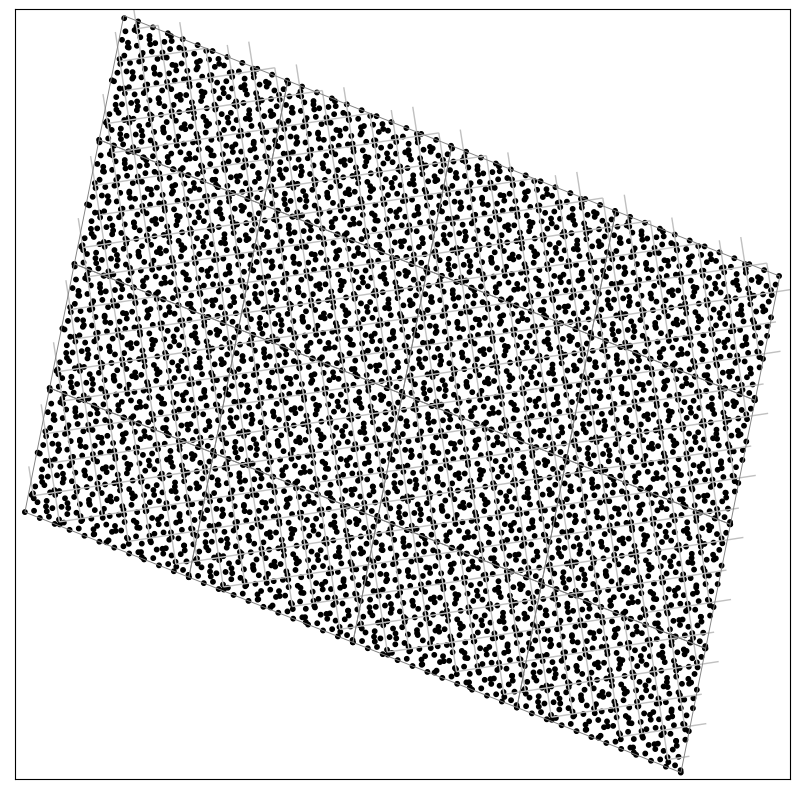

1

In [59]:
s.SuperRed.showXY(4,4)

In [ ]:
a,b=s.redes[0].a,s.redes[0].b

In [ ]:
sa,sb = m2V(a,b,(2,1)),m2V(a,b,(-1,1))
sa,sb

In [ ]:
a,b=s.redes[1].a,s.redes[1].b
sc,sd = m2V(a,b,(1,2)),m2V(a,b,(-2,3))
sc,sd

In [ ]:
sr=superMesh(sa,sb,[s.redes[0]])

In [ ]:
sr.showXY(4,4)

In [ ]:
s.redes[0].showme()
s.redes[1].showme()

In [ ]:
M=vTm((5,-6),(0,3))

In [ ]:
a,b = transforma2v(s.redes[0].a,s.redes[0].b,M)
c,d = transforma2v(s.redes[0].a,s.redes[0].b,M2)
a,b,c,d#,esRotacion(a,b,c,d)

In [ ]:
M2=[[0, 5], [-3, -6]]

In [ ]:
det(M2)

In [ ]:
cAng((16.530549526, -27.314509391999998),(16.530549526, -27.314509391999998))

In [ ]:
(u1,u2),(v1,v2) = u,v = (16.530549526, -27.314509391999998),(16.530549526, -27.314509391999998)
((u1*v1)+(u2*v2)),(dist((0,0),u)*dist((0,0),v))

In [ ]:
math.degrees(math.acos(1.0000000000000002))

In [ ]:
((u1*v1)+(u2*v2))/(dist((0,0),u)*dist((0,0),v))

In [ ]:
mt=[[0, 7], [-6, 8]]
a,b = transforma2v(s.redes[0].a,s.redes[0].b,mt)
t=cAng(a,b)
det(mt),t,a,b

In [ ]:
s.creaSuperRed(mt)

In [ ]:
s.SuperRed.showme()

In [19]:
r2.inAngle

90.0

In [60]:
s.SuperRed.exporta()

1

In [74]:
tam=(2.44)*(1-0.05)
tam2=2.44
vct=(tam,0)
aux1,aux2=transfVs(vct,rota(vct,120),(4,8,-8,12))
A,B=transforma2v(aux1,aux2,inv2x2([[-8,12],[-11,4]]))
print(m2V(A,B,(6,2)))
print(A,B)

(2.318000000000003, 12.044681315833975)
(1.2517200000000006, 2.007446885972329) (-2.5961600000000002, 0.0)


In [75]:
g1=grafeno()
g2=grafeno()

(2.318000000000003, 12.044681315833975)
(1.2517200000000006, 2.007446885972329) (-2.5961600000000002, 0.0)
Tam vectores:2.3657231364637754,2.5961600000000002
Angulo interno: 121.94534081700915
% de distorción:-3.0441337514846123,6.400000000000006 3.3558662485153934
Tam medio=2.480941568231888
Coorelación:1.070294032886923


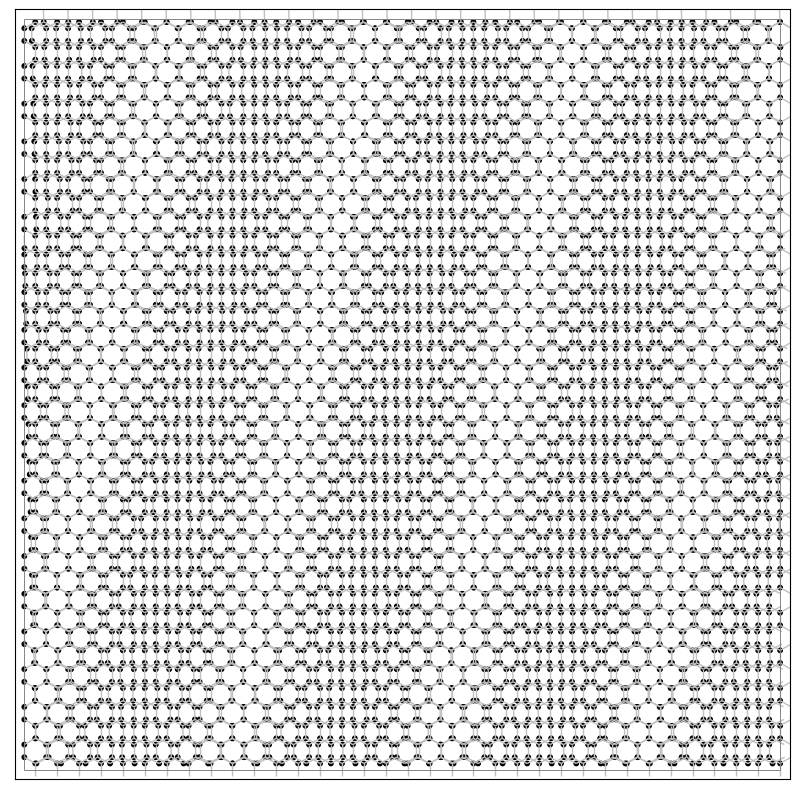

In [83]:
tam=(2.44)*(1-0.05)
tam2=2.44
vct=(tam,0)
aux1,aux2=transfVs(vct,rota(vct,120),(4,8,-8,12))
A,B=transforma2v(aux1,aux2,inv2x2([[-8,12],[-11,4]]))
print(m2V(A,B,(6,2)))
print(A,B)
#print(m2V(vec1,rota(vec1,120),(4,6)))
print("Tam vectores:{},{}".format(dist((0,0),A),dist(B,(0,0))))
print("Angulo interno:",cAng(A,B))
d1,d2=((dist((0,0),A)/tam2)-1)*100,((dist(B,(0,0))/tam2)-1)*100
print("% de distorción:{},{}".format(d1,d2),d1+d2)
tm = (dist((0,0),A)+dist(B,(0,0)))/2
print("Tam medio={}\nCoorelación:{}".format(tm,tm/tam))
#(vec1,rota(vec1,120))
g1.setNewVectors(vct,rota(vct,120))
g2.setNewVectors(A,B)
superMesh((80,0),(0,80),[g1,g2]).showme()

In [89]:
[g1.a,g1.b,g2.a,g2.b],aux1,aux2

([(2.318, 0),
  (-1.1589999999999996, 2.007446885972329),
  (1.2517200000000006, 2.007446885972329),
  (-2.5961600000000002, 0.0)],
 (18.543999999999997, -16.059575087778633),
 (4.636000000000006, 24.08936263166795))

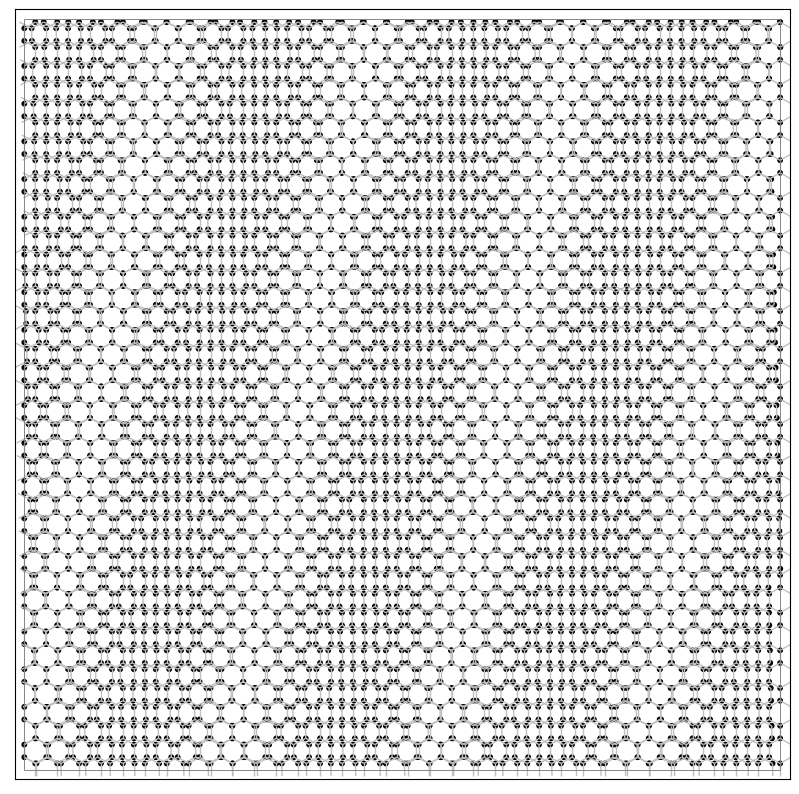

In [85]:
graf1=grafeno()
graf2=grafeno()
graf1.setNewVectors((2.318, 0),(-1.1589999999999996, 2.007446885972329))
graf2.setNewVectors((-2.5961600000000002, 0.0),(1.2517200000000006, 2.007446885972329))
superMesh((80,0),(0,80),[graf1,graf2]).showme()

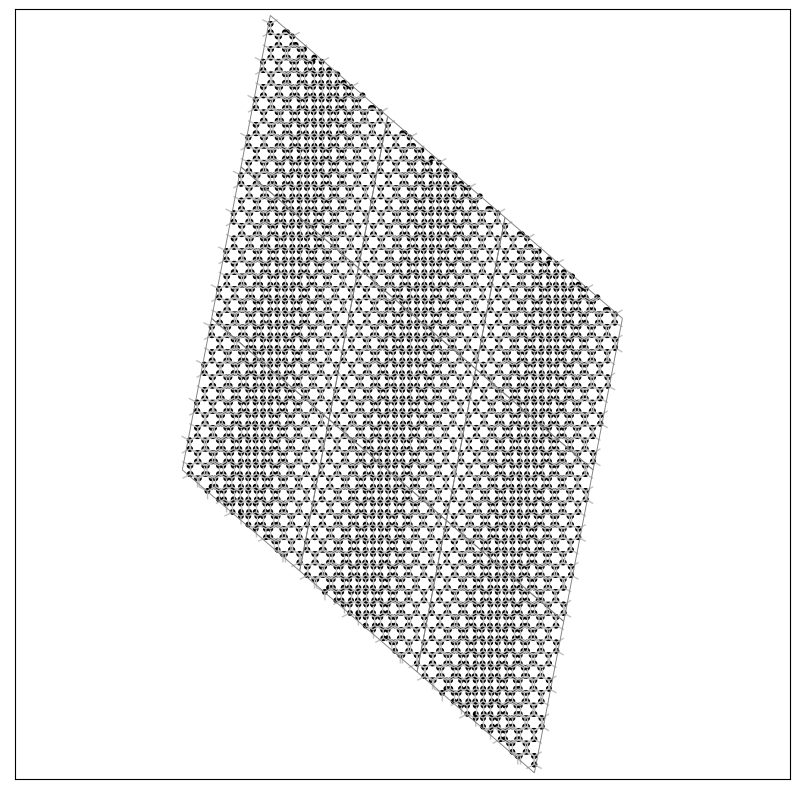

In [88]:
gg=superMesh(aux1,aux2,[graf1,graf2]).showXY(3,3)